![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Applied_Generative_AI/Combining_LLM_Pipelines.ipynb)

# LLMs in Spark NLP

## **🎬 Colab Setup**

In [1]:
%pip install -q spark-nlp pyspark==3.5.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 682.6 kB/s eta 0:00:00


In [1]:
import sparknlp
from sparknlp.annotator import T5Transformer, AutoGGUFModel
from sparknlp.base import DocumentAssembler, Pipeline
import pyspark.sql.functions as F
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

params = {
    "spark.driver.memory": "12G",
    "spark.kryoserializer.buffer.max": "2000M",
    "spark.driver.maxResultSize": "2000M",
}


use_gpu = False
spark = sparknlp.start(params=params, gpu=use_gpu)
spark.sparkContext.setLogLevel("ERROR")

## Out-of-the-box LLMs

Spark NLP offers multiple annottors to use LLM for different tasks:

- Text Summarization
- Text Generation
- Neural Machine Translation
- Question-Answering


One category of models we support is based on the (Flan) T5, a model released by Google. We will show how to use one of the pretrained models to perform **Question-Answering**.

The T5 model can perform multiple tasks using specific constructs on the input text. Called **instruction prompts**, we format the input giving one instruction (`summarize: {text}` for text summarization, `question: {question} context: {context}` for open-book QA, etc.). Flan T5 improves on T5 model to generalize for tasks not trained on the T5 model.

Pretrained models can be found on [Spark NLP Models Hub](https://nlp.johnsnowlabs.com/models).

Resources:

* [T5 Research paper](https://jmlr.org/papers/volume21/20-074/20-074.pdf): technical detail on the model.
* [T5 Github repo](https://github.com/google-research/text-to-text-transfer-transformer): official implementation by the researchers
* [Flan T5 Research paper](https://arxiv.org/pdf/2210.11416.pdf): technical detail on the model
* [Flan T5 GitHub Repo](https://github.com/google-research/t5x): official implementation of the models
* [John Snow Labs Notebook on T5](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/open-source-nlp/13.1.T5_Workshop_with_SparkNLP.ipynb): detail on how to use T5 on all the available tasks
* [John Snow Labs Notebook on Q&A and Summarization with T5](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/open-source-nlp/13.0.T5_Question_Answering_and_Summarization_with_SparkNLP.ipynb): specific examples fro Q&A and Summarization using T5

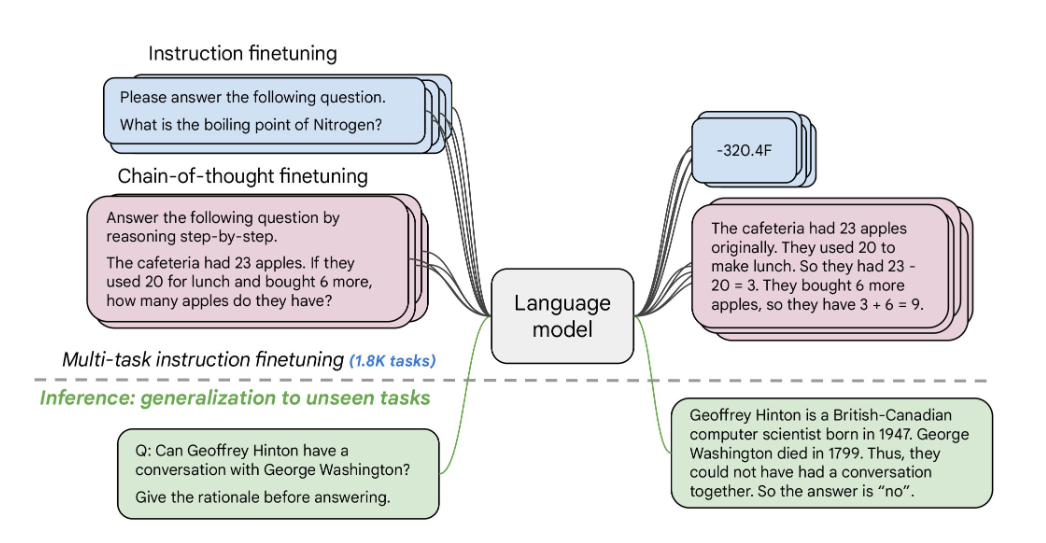

### What is a `open book question`?


You can imagine an `open book` question similar to an examen where you are allowed to bring in text documents or cheat sheets that help you answer questions in an examen. Kinda like bringing a history book to an history examen.

In `T5's` terms, this means the model is given a `question` and an **additional piece of textual information** or so called `context`.

This enables the `T5` model to answer questions on textual datasets like `medical records`,`newsarticles` , `wiki-databases` , `stories` and `movie scripts` , `product descriptions`, 'legal documents' and many more.

### What is a `closed book question`?

A `closed book question` is the exact opposite of a `open book question`. In an examen scenario, you are only allowed to use what you have memorized in your brain and nothing else.      
In `T5's` terms this means that T5 can only use it's stored weights to answer a `question` and is given **no aditional context**.        
`T5` was pre-trained on the [C4 dataset](https://commoncrawl.org/) which contains **petabytes  of web crawling data**  collected over the last 8 years, including Wikipedia in every language.

In [11]:
documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

llm = (
    T5Transformer.pretrained("t5_base", "en")
    .setInputCols("document")
    .setOutputCol("answers")
    .setTask("question: ")
)

pipeline = Pipeline(stages=[documentAssembler, llm])

t5_base download started this may take some time.
Approximate size to download 451.8 MB
[OK!]


### Answer **Closed Book Questions**  
Closed book means that no additional context is given and the model must answer the question with the knowledge stored in it's weights.

*T5 models were released in 2019 and Flan T5 ones in 2022, so recent information is outdated in their internal knowledge.*

In [12]:
# define Data

# For closed book question we don't need to add the keyword for questions (defined with `.setTask`)
data = [
    ["Who is president of the US? "],
    ["What is the most common language in Peru?"],
    ["What is the capital of Germany? "],
]
df = spark.createDataFrame(data).toDF("text")

In [13]:
# Predict on text data with T5

model = pipeline.fit(df)
annotated_df = model.transform(df)
annotated_df.select(["text", "answers.result"]).show(truncate=False)

+-----------------------------------------+--------------+
|text                                     |result        |
+-----------------------------------------+--------------+
|Who is president of the US?              |[Donald Trump]|
|What is the most common language in Peru?|[Spanish]     |
|What is the capital of Germany?          |[Berlin]      |
+-----------------------------------------+--------------+



### Answer **Open Book Questions**
These are questions where we give the model some additional context, that is used to answer the question.

*This approach limits hallucinations as the models need to use the given context to answer the questions, similar to the RAG approach that searches for relevant context in a vector store.*

In [14]:
context = """Spark NLP is a state-of-the-art Natural Language Processing library built on top of Apache Spark.
It provides simple, performant & accurate NLP annotations for machine learning pipelines that scale easily in a distributed environment.
Spark NLP comes with 36000+ pretrained pipelines and models in more than 200+ languages.
"""

# Add the keyword `context: `(T5 approach)
context = f"context: {context}"

# For open book questions, we need to add the keyword for questions too.
question1 = "What is Spark NLP? "
question2 = "How many languages are supported in Spark NLP? "
question3 = "Can I use Spark NLP to scale my NLP application? "

data = [
    [question1, f"question: {question1}" + context],
    [question2, f"question: {question2}" + context],
    [question3, f"question: {question3}" + context],
]


df = spark.createDataFrame(data, ["question", "text"]).toDF("question", "text")

# Predict on text data with T5

model = pipeline.fit(df)
annotated_df = model.transform(df)
print(context)
annotated_df.select(["question", "answers.result"]).show(truncate=False)

context: Spark NLP is a state-of-the-art Natural Language Processing library built on top of Apache Spark.
It provides simple, performant & accurate NLP annotations for machine learning pipelines that scale easily in a distributed environment.
Spark NLP comes with 36000+ pretrained pipelines and models in more than 200+ languages.

+-------------------------------------------------+-------------------------------------+
|question                                         |result                               |
+-------------------------------------------------+-------------------------------------+
|What is Spark NLP?                               |[Natural Language Processing library]|
|How many languages are supported in Spark NLP?   |[200+]                               |
|Can I use Spark NLP to scale my NLP application? |[easily in a distributed environment]|
+-------------------------------------------------+-------------------------------------+



## **Auto GGUF With LLMs**

### Document Splitting


In [2]:
document_assembler = (
    DocumentAssembler().setInputCol("text").setOutputCol("document")
)

llm = (
    AutoGGUFModel.pretrained("qwen2.5_0.5b_instruct_q8_0", "en")
    .setInputCols(["document"])
    .setOutputCol("summary")
    .setSystemPrompt("Summarize the given text")
)

qwen2.5_0.5b_instruct_q8_0 download started this may take some time.
Approximate size to download 482.8 MB
[OK!]


In [ ]:
pipeline = Pipeline(
    stages=[document_assembler, llm]
).fit(spark.createDataFrame([["text"]]).toDF("text"))


In [4]:
spark_df = spark.createDataFrame([[
    "Transfer learning, where a model is first pre-trained on a data-rich task before being fine-tuned on a " +
    "downstream task, has emerged as a powerful technique in natural language processing (NLP). The effectiveness" +
    " of transfer learning has given rise to a diversity of approaches, methodology, and practice. In this " +
    "paper, we explore the landscape of transfer learning techniques for NLP by introducing a unified framework " +
    "that converts all text-based language problems into a text-to-text format. Our systematic study compares " +
    "pre-training objectives, architectures, unlabeled data sets, transfer approaches, and other factors on dozens " +
    "of language understanding tasks. By combining the insights from our exploration with scale and our new " +
    "Colossal Clean Crawled Corpus, we achieve state-of-the-art results on many benchmarks covering " +
    "summarization, question answering, text classification, and more. To facilitate future work on transfer " +
    "learning for NLP, we release our data set, pre-trained models, and code."
]]).toDF("text")

In [6]:
pipeline.transform(spark_df).select(
    "summary.result"
).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|result                                                                                                       |
+-------------------------------------------------------------------------------------------------------------+
|[Transfer learning is a technique that involves training a model on a large dataset before fine-tuning it on]|
+-------------------------------------------------------------------------------------------------------------+

